# Book Recommender---Part 5(Collaborative filtering with latent factor models)

This part of approach is largely inspired by [this paper](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)

Latent factor models are an approach that tries to explain the ratings by charactrering both items and users on. Some of the most successful realization of latent factor models are based on matrix factorization. In its basic form, matrix factorization charactrizes both items and users by vectors of factors inferred form item rating patterns. High correspondence between item and users facotrs leads to a recommendation.

Matrix factorizaiton models map both users and items to a joint latent facotr space of dimensionality of f, such that user-item interactions are modeled as inner products in that space. Accordingly, each item i is associated with a vector $q_i∈R^f$, and each user u is associated with a vector $p_u∈R^f$. For a given item i, the element of $q_i$ measures those factors, positve or negative. For given user u, the elements of $p_u$ measure the extent of interest the user has in items that are high on the corresponding factors, again, positive or negative. 

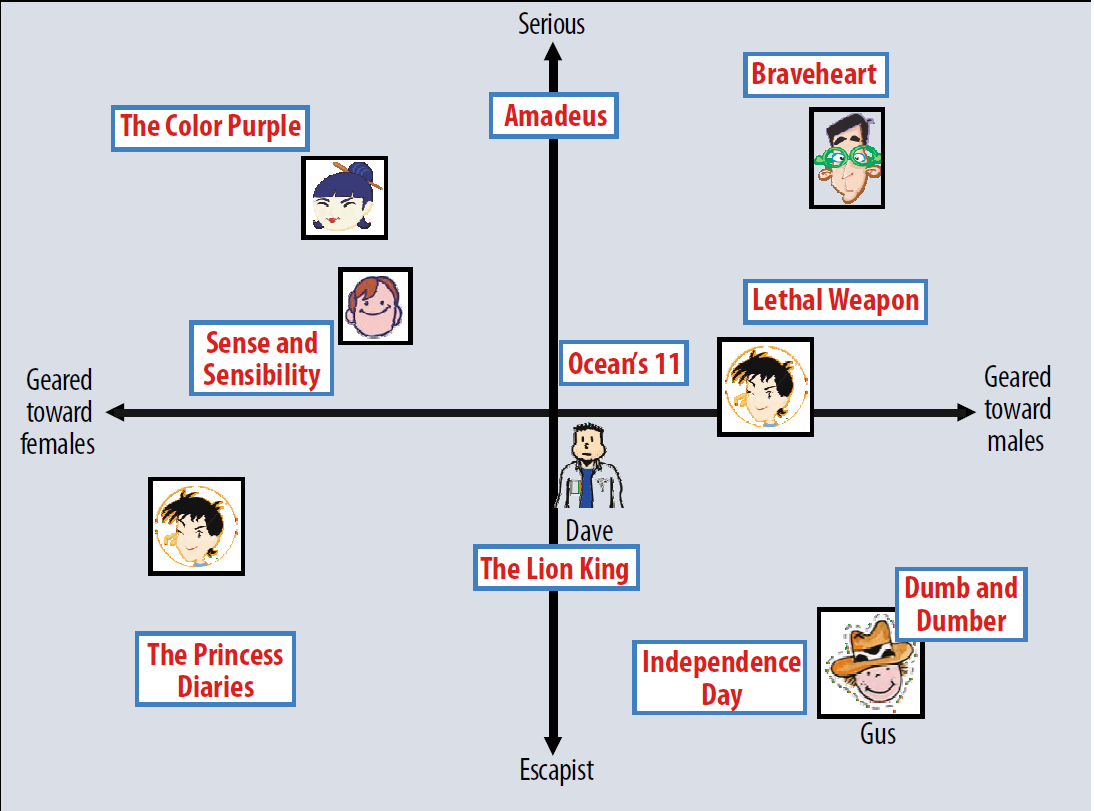

The above figure illustrates this idea for a simplified example in two dimensions. Consider two hypothetical dimensions characterized as female- versus male-oriented and serious versus escapist. The figure shows where several well-known movies and a few fictitious users might fall on these two dimensions. For this model, a user’s predicted rating for a movie, relative to the movie’s average rating, would equal the dot product of the movie’s and user’s locations on the graph. For example, we would expect Gus to love Dumb and Dumber, to hate The Color Purple, and to rate Braveheart about average. Note that some movies— for example, Ocean’s 11—and users—for example, Dave—would be characterized as fairly neutral on these two dimensions.

The resulting dot product,$q_i^Tp_u$, captures the interaction between user u and item i--the user's overall interest in the item's characteristcis. This approximates user u's rating of item i, which is denoted by $r_{ri}$,leading to the estimate
$$\hat{r_{ui}}=q_i^Tp_u$$

In order to compute the $q_i∈R^f$ and $p_u∈R^f$, We minimize the regularized squared error on the set of konwn ratings:
$$minimize(\sum_{u,i∈k}(r_{ui}-q_i^Tp_u)^2+λ(||q_i||^2+||p_u||^2))$$
here k is the set of (u,i) pairs for which $r_{ui}$ is known(in training set)

Alternating least squares approach to learn the optimized $q_i∈R^f$ and $p_u∈R^f$: if we fix one of the $q_i$ and $p_u$, the optimization problem becomes quadratic and can be solved optimally. ALS tecniques rotate between fixing the $q_i$'s and the $p_u$'s. When all $p_u$'s are fixed, the sysytem recomputes the $q_i$'s by solving a least-square problem, and vice versa. This ensure that each step decreases in above equation until convergence.



In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import re
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from scipy import sparse

from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# 1. Construct user_book matrix

In [2]:
books_df=pd.read_csv('./goodreads/books.csv')
books_df['bookID']=books_df['bookID'].astype('str')
books_df['authorID']=books_df['authorID'].astype('str')
ratings=pd.read_csv('./goodreads/final_ratings.csv')
ratings['bookID']=ratings['bookID'].astype('str')
ratings['userID']=ratings['userID'].astype('str')
ratings=ratings[ratings['bookID'].isin(books_df['bookID'])] # remove the books which is not in books_df
ratings['user_count']=ratings.groupby('userID')['userID'].transform('count') 
ratings=ratings[ratings['user_count']>20] #only train the model to user who have rated no less than 20 books
userid_list=ratings['userID'].unique()

In [3]:
#split the data into train and test
train, test = train_test_split(ratings,
                               stratify=ratings['userID'], 
                               test_size=0.20,
                               random_state=42)

In [4]:
#create the idx to bookid dictionary and bookid to idx dictionary
idx_to_bookid=books_df['bookID'].to_dict()
bookid_to_idx={}
for k,v in idx_to_bookid.items():
    bookid_to_idx[v]=k
num_books=len(idx_to_bookid)
print(f"number of books={num_books}")

number of books=2970


In [5]:
#create the idx to userid dictionary and userid to idx dictionary
idx_to_userid=dict(enumerate(train['userID'].unique()))
userid_to_idx={}
for k,v in idx_to_userid.items():
    userid_to_idx[v]=k
num_users=len(idx_to_userid)
print(f"number of users={num_users}")

number of users=3512


In [6]:
#construct the user_book matrix
user_book_matrix=np.zeros((num_users,num_books))
for _,row in train.iterrows():
    user_book_matrix[userid_to_idx[row['userID']],bookid_to_idx[row['bookID']]]=row['rating']

# 2. Alternate Least Square learning algorithm

In [7]:
#compute approximate of ratings with U and B
def new_R(matrix, U, B):
    new_ratings = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i,j]>0: #only compute observed rating
                new_ratings[i,j]=B[:, j] @ U[i, :]
    return new_ratings

In [8]:
# Alternate Least Square to learn the optimized U and B, matrix is the user-book matrix 
# k is the demensionality of the latent factor,lamu and lamb is the learing rate
def ALS(matrix, k=3, lamu = 0.1, lamb = 0.1):
    # Initialize U and B
    U = np.ones((num_users, k)) / np.sqrt(k)
    B = np.ones((k, num_books)) / np.sqrt(k)
    
    iteration = 1
    RMSE = 3
    dRMSE = 1
    rmse = []
    stop = 0.0001
    max_iter = 10
    
    while (dRMSE > stop) and (iteration < max_iter):
        #iterate each user, update U
        for i in range(matrix.shape[0]):
            ind_B = matrix[i,:]>0
            sub_B = B[:, ind_B] #(k,number of books this user has rated)
            Ai = sub_B @ np.transpose(sub_B) + lamu * np.identity(k) #(k,k)
            Vi = sub_B @ matrix[i,matrix[i,:]>0] #(k,)
            U[i, :] = np.linalg.pinv(Ai) @ Vi #update the ith row of U,represents the ith user
        nR = new_R(matrix, U, B)
        new_RMSE =np.sqrt(np.mean((nR-matrix)**2))
        dRMSEu = (RMSE - new_RMSE)
        RMSE = new_RMSE.copy()
        rmse.append(RMSE)
        print("step: ", iteration)
        iteration += 1
        #iterate each book, update B
        for j in range(matrix.shape[1]):
            ind_U = matrix[:,j]>0
            sub_U = U[ind_U, :] #(number of users has rated this book,k)
            Ai = np.transpose(sub_U) @ sub_U + lamb * np.identity(k) #(k,k)  
            Vi = np.transpose(sub_U) @ matrix[matrix[:,j]>0,j] #(k,)
            B[:, j] = np.linalg.pinv(Ai) @ Vi #update the jth column of B, represents the jth book
        nR = new_R(matrix, U, B)
        new_RMSE =np.sqrt(np.mean((nR-matrix)**2))
        dRMSE = (RMSE - new_RMSE) #np.abs
        RMSE = new_RMSE.copy()
        print("step: ", iteration)
        iteration += 1
        rmse.append(RMSE)
    return rmse,U,B

In [9]:
#compute the ratings with optimized U and B
def predict_R(U, B):
    pred_ratings = np.zeros((U.shape[0],B.shape[1]))
    for i in range(U.shape[0]):
        for j in range(B.shape[1]):
                pred_ratings[i,j]=B[:, j] @ U[i, :]
    return pred_ratings

In [10]:
#predict ratings for whole dataset, then compute the rmse for test datset
train_rmse,U,B = ALS(user_book_matrix)
pred_ratings=predict_R(U, B)
pred_ratings[pred_ratings>5]=5
pred_ratings[pred_ratings<1]=1
rating_pred=[]
for _,row in test.iterrows():
    idx_book=bookid_to_idx[row['bookID']]
    idx_user=userid_to_idx[row['userID']]
    rating_pred.append(pred_ratings[userid_to_idx[row['userID']],bookid_to_idx[row['bookID']]])            
rmse=np.sqrt(np.mean((test['rating']-rating_pred)**2))
rmse

step:  1
step:  2
step:  3
step:  4
step:  5
step:  6


0.9639441134489884

# 3. Recommend top 10 books for a user

In [11]:
def recommend_books(user_book_matrix,pred_ratings,books_df,userid,N=10):
    user_idx=userid_to_idx[userid]
    unrated=books_df[user_book_matrix[user_idx,:]==0][['title','rating']]
    unrated['pred_rating']=pred_ratings[user_idx,user_book_matrix[user_idx,:]==0]
    return unrated.sort_values('pred_rating',ascending=False)[:10]
    

In [12]:
recommend_books(user_book_matrix,pred_ratings,books_df,userid='2745288',N=10)

,title,rating,pred_rating
402,Cutters Don't Cry,4.00,5.000000
1949,The Quirky Tale of April Hale,4.14,4.633431
302,The Heart of Aleppo: A Story of the Syrian Civ...,4.34,4.503117
1620,Words of Radiance,4.75,4.382847
1212,Kestrel's Midnight Song,4.01,4.367595
1424,The Changeling,4.18,4.331737
382,The Light of Cabo Rojo,4.68,4.309774
630,After School With Mr. Obnoxious,3.65,4.282097
2812,"Boat Kid: How I Survived Swimming with Sharks,...",4.16,4.274175
1233,The Pandarus File,4.43,4.257987
